In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [17]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [18]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [19]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [20]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [21]:

#Finding columns and datatype
from sqlalchemy import inspect,func
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [36]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).limit(5).all()
last_date[0][0]
# Calculate the date 1 year ago from the last data point in the database
precipitation_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

# Perform a query to retrieve the data and precipitation scores
precipitation_df = pd.DataFrame(precipitation_data, columns = ['date', 'precipitation'])

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df.set_index('date', inplace = True)
precipitation_df.head()

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by = 'date')
precipitation_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.describe()



,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


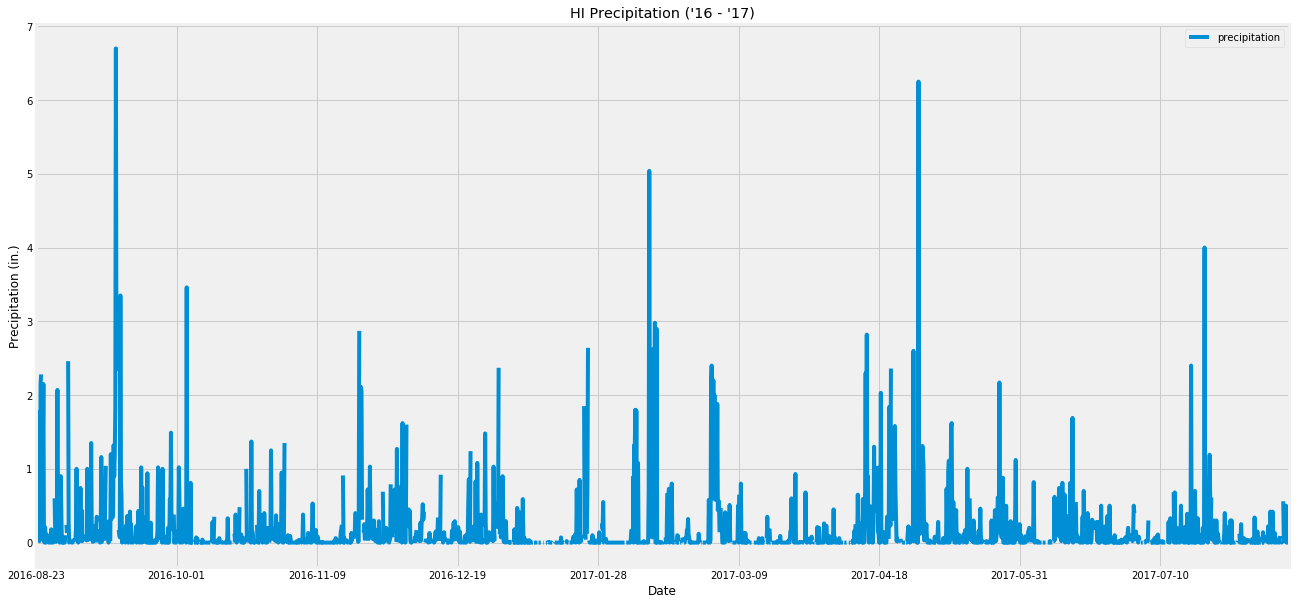

In [37]:
# Use Pandas to calcualte the summary statistics for the precipitation data
fig, ax = plt.subplots(figsize = (20, 10))
precipitation_df.plot(ax = ax, x_compat = True)

# format plot
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in.)')
ax.set_title("HI Precipitation ('16 - '17)")

# save plot
plt.savefig("Images/precipitation.png")

# display plot
plt.show()

In [38]:
# Design a query to show how many stations are available in this dataset?
station_num = session.query(Station.id).distinct().count()
station_num

9

In [39]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_rows = session.query(Station.station, func.count(Measurement.id)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Measurement.id).desc()).all()

for result in station_rows:
    print(f"{result[0]}\tCount: {result[1]}")

USC00519281	Count: 2772
USC00519397	Count: 2724
USC00513117	Count: 2709
USC00519523	Count: 2669
USC00516128	Count: 2612
USC00514830	Count: 2202
USC00511918	Count: 1979
USC00517948	Count: 1372
USC00518838	Count: 511


In [41]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = 'USC00519281'
most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()
print(f"Lowest Temperature: {most_active_temps[0][0]} Fahrenheit, Highest Temperature: {most_active_temps[0][1]} Fahrenheit, Average Temperature: {round(most_active_temps[0][2], 2)} Fahrenheit  ")

Lowest Temperature: 54.0 Fahrenheit, Highest Temperature: 85.0 Fahrenheit, Average Temperature: 71.66 Fahrenheit  


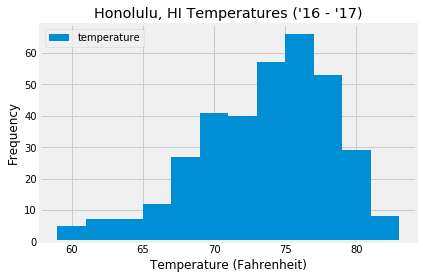

In [43]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temps = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

year_temps_df = pd.DataFrame(year_temps, columns = ['date', 'temperature'])

# Set index by date
year_temps_df.set_index('date', inplace = True)

#Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
year_temps_df.plot.hist(bins = 12, ax = ax)

#set labels
ax.set_xlabel('Temperature (Fahrenheit)')
ax.set_ylabel('Frequency')
ax.set_title("Honolulu, HI Temperatures ('16 - '17)")

#save figure
plt.savefig("Images/temperature_history.png")

#plot

plt.show()

## Bonus Challenge Assignment

In [44]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [45]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-02-06', '2017-02-16')

print(f"Lowest Temperature: {trip_temps[0][0]} Fahrenheit, Average Temperature: {round(trip_temps[0][1], 2)} Fahrenheit, Highest Temperature: {trip_temps[0][2]} Fahrenheit")

Lowest Temperature: 59.0 Fahrenheit, Average Temperature: 70.42 Fahrenheit, Highest Temperature: 80.0 Fahrenheit


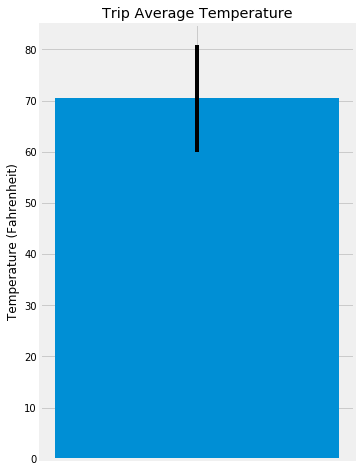

In [47]:
# Plot the results from your previous query as a bar chart. 

# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
peak_to_peak = trip_temps[0][2] - trip_temps[0][0]
average_temp = trip_temps[0][1]

# plot chart
fig, ax = plt.subplots(figsize = (5, 8))

ax.bar(1, average_temp, yerr = peak_to_peak/2, width = 0.5)

#set labels
ax.set_xticks([1])
ax.set_xticklabels([""])
ax.set_title('Trip Average Temperature')
ax.set_ylabel('Temperature (Fahrenheit)')

#save fig
plt.savefig("Images/trip_avg_temp")

#show figure

plt.show()

In [48]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sta_yearly_prec= session.query(Station.station, Station.name, Station.latitude, Station.longitude,
                               Station.elevation, func.avg(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).group_by(Station.station).\
    order_by(func.avg(Measurement.prcp).desc()).all()

#load into a dataframe
syc_df = pd.DataFrame(sta_yearly_prec, columns = ['Station', 'Name', 'Latitude', 'Longitude', 
        'Elevation', 'Avg. Precipitation (in.)'])

syc_df

,Station,Name,Latitude,Longitude,Elevation,Avg. Precipitation (in.)
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.450640
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.198949
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.141429
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.125434
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.121051
5,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.076500
6,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.044819


In [49]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [56]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the tripcurrent_year=latest_date.year
current_year=latest_date.year
start_date=str(current_year)+'-02-28'
end_date=str(current_year)+'-03-05'


# Use the start and end date to create a range of dates
results=session.query(Measurement.date).order_by(Measurement.date.asc()).\
       filter(Measurement.date>=start_date).\
       filter(Measurement.date<=end_date).distinct()
# Stip off the year and save a list of %m-%d strings
date_trip_df=pd.DataFrame(results.all())
normal=date_trip_df['date'].str.slice(start=5)
date_trip_df = date_trip_df.set_index('date')
# Loop through the list of %m-%d strings and calculate the normals for each date
daily_norms=[]
for month_date in range(len(normal)):
    daily_value=daily_normals(normal[month_date])[0]
    daily_norms.append(tuple(daily_value))
daily_norms

[(65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [57]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
data_df=pd.DataFrame(daily_norms)

date_trip_df['tmin']=data_df[0].tolist()
date_trip_df['tavg']=data_df[1].tolist()
date_trip_df['tmax']=data_df[2].tolist()
date_trip_df

,tmin,tavg,tmax
date,,,
2017-02-28,65.0,70.655172,80.0
2017-03-01,64.0,70.032787,76.0
2017-03-02,61.0,70.366667,78.0
2017-03-03,60.0,70.068966,78.0
2017-03-04,57.0,69.272727,77.0
2017-03-05,60.0,67.890909,76.0


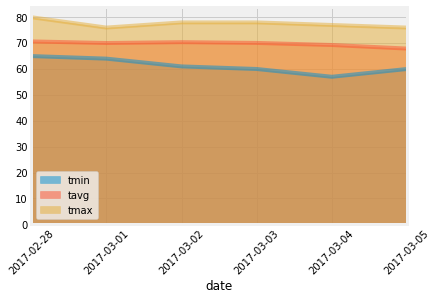

In [59]:
# Plot the daily normals as an area plot with `stacked=False`
ax = date_trip_df.plot.area(stacked=False)
plt.xticks(rotation=45)
plt.show()